In [3]:
from hmmlearn.hmm import GMMHMM
import numpy as np
import pandas as pd
from pyhhmm.heterogeneous import HeterogeneousHMM
from matplotlib import pyplot as plt
import pyhhmm.utils as ut
import kagglehub
import matplotlib.colors as mcolors

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def separate_games(df: pd.DataFrame) -> list[pd.DataFrame]:
    """Separate dataframe into separate games via the game ID. Place into a 
    list of games. Indices are reindexed so plays are numbered, starting with 0
    """
    games = [df[df['GameID'] == value].reset_index(drop=True) for value in df['GameID'].unique()]
        
    return games

def separate_years(df: pd.DataFrame) -> list[pd.DataFrame]:
    """Separates the games by which season in which they occured. Outputs a list of seasons."""
    seasons = [df[df['Season'] == value].reset_index(drop=True) for value in df['Season'].unique()]
    
    return seasons

def calculate_time_per_play(game: pd.DataFrame) -> pd.DataFrame:
    """Create a new column which is the time each play took.
    Kicks will have NANs in the new play_time column, which should make them easy to remove
    """
    game['play_time'] = -game['TimeSecs'].diff()

    return game


def drop_unnecessary_rows(game: pd.DataFrame) -> pd.DataFrame:
    """The end of each quarter is its own row. Same with timeouts
    and the end of the game. Other values are mostly NANs.
    This removes all of those unhelpful rows and reindexes

    NOTE: plays must be indexed starting with their first play
    TODO: Might be able to just drop rows with missing posteam
    """
    # find indices
    game.dropna(subset=['posteam', 'play_time'], inplace=True)
    # reset index
    game = game.reset_index(drop=True)

    return game

def encode_teams(game: pd.DataFrame) -> pd.DataFrame:
    """Change all team names to just 0s or 1s. This won't be retraceable if you are
    looking for a game with a specific team playing.
    """
    teams = game['posteam'].unique()
    if len(teams) != 2:
        print(teams)
        raise ValueError("Dataset has not been properly cleaned. There are more than 2 values in posteam.")
    
    home_team = game["HomeTeam"][0]
    team_map = {team:0 if team == home_team else 1 for team in teams} # NOTE: this now marks the home team as team 0
    game['posteam'] = game['posteam'].map(team_map)
    game['DefensiveTeam'] = game['DefensiveTeam'].map(team_map)

    return game

def create_team0_yardage(game: pd.DataFrame) -> pd.DataFrame:
    """Create a new column which is the yards gained in the play by team zero. 
    It is negative if team 1 is in posession and gains yards.
    """
    game['hometeam_yards'] = np.where(game['posteam'] == 0, game['Yards.Gained'], -game['Yards.Gained'])

    return game

def no_overtime(game: pd.DataFrame) -> pd.DataFrame:
    """Discard all data on overtime periods. 
    Will result in another Dataframe
    """
    game = game[game["qtr"]!=5]
    return game
    

# Of note: Yards.Gained
# TODO: column of yards gained for team 0, when team 1 gains yards, value is negative
# TODO: keep nans in until you calculate time per play
#   then delete those rows like before and replace nans in time per play with
#   average time per play in that game

In [5]:
# Download latest version
path = kagglehub.dataset_download("maxhorowitz/nflplaybyplay2009to2016")

print("Path to dataset files:", path)

Path to dataset files: /Users/henryfetzer/.cache/kagglehub/datasets/maxhorowitz/nflplaybyplay2009to2016/versions/6


In [6]:
df = pd.read_csv(path + "/NFL Play by Play 2009-2016 (v3).csv")

# split seasons
seasons = separate_years(df)

# split games from season 1
season = seasons[1]
games = separate_games(season)

# clean all games
for i, game in enumerate(games):
    games[i] = no_overtime(game)
    games[i] = calculate_time_per_play(game)
    games[i] = drop_unnecessary_rows(games[i])
    games[i] = encode_teams(games[i])
    games[i] = create_team0_yardage(games[i])
    games[i] = no_overtime(games[i]) # new

# recombine
df = pd.concat(games, ignore_index=True)

# choose game 50 for no particular reason
game = games[50]

/var/folders/zl/1w6b2xdd3k1djjqk561_wwr40000gr/T/ipykernel_771/1347595952.py:1: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/NFL Play by Play 2009-2016 (v3).csv")


In [7]:
columns_to_keep = ['hometeam_yards', 'play_time', 'posteam', 'Yards.Gained', 'qtr']
reduced_game = game.loc[:, columns_to_keep]

# Create observations
first_half = reduced_game[reduced_game['qtr'].isin([1, 2])]
second_half = reduced_game[reduced_game['qtr'].isin([3, 4])]
second_posessions = second_half.loc[:, 'posteam']
observations = first_half.loc[:, ['Yards.Gained', 'posteam']].to_numpy()
print(observations.shape)

(74, 2)


## Try the Heterogeneous HMM

In [8]:
# Initialize the model
my_hmm = HeterogeneousHMM(
    n_states=4, # experiment with this
    n_g_emissions=1,   # number of continuous observations
    n_d_emissions=1,    # number of discrete observations
    n_d_features=[2],    # number of possible values for each discrete variable
    covariance_type="diagonal",
    verbose=True
    )

# Train
my_hmm, log_likelihood = my_hmm.train([observations], n_init=10, n_iter=10)

Initialisation 1


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -337.1690007705226, delta = nan
iter: 1, log_likelihood = -282.3602884930473, delta = 54.80871227747531
iter: 2, log_likelihood = -279.89701897526476, delta = 2.4632695177825212
iter: 3, log_likelihood = -278.2444200712039, delta = 1.6525989040608806
iter: 4, log_likelihood = -276.561647908121, delta = 1.6827721630828592
iter: 5, log_likelihood = -274.47479058933106, delta = 2.086857318789953
iter: 6, log_likelihood = -271.3941459243525, delta = 3.0806446649785926
Converged -> iter: 6, log_likelihood = -271.3941459243525
Initialisation 2


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -355.71425681670064, delta = nan
iter: 1, log_likelihood = -283.4189172347427, delta = 72.29533958195793
iter: 2, log_likelihood = -280.9376685253473, delta = 2.481248709395402
iter: 3, log_likelihood = -279.5087221145883, delta = 1.4289464107590106
iter: 4, log_likelihood = -277.28257533129295, delta = 2.2261467832953485
iter: 5, log_likelihood = -273.2295808840295, delta = 4.0529944472634725
iter: 6, log_likelihood = -269.64672105666364, delta = 3.582859827365837
Converged -> iter: 6, log_likelihood = -269.64672105666364
Initialisation 3


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -339.69049753393466, delta = nan
iter: 1, log_likelihood = -282.8270339702604, delta = 56.86346356367426
iter: 2, log_likelihood = -280.9061393782077, delta = 1.9208945920527185
iter: 3, log_likelihood = -279.6950236618208, delta = 1.211115716386871
iter: 4, log_likelihood = -278.5401234188851, delta = 1.154900242935696
iter: 5, log_likelihood = -277.1006271633482, delta = 1.4394962555369375
iter: 6, log_likelihood = -274.52524251745643, delta = 2.575384645891745
Converged -> iter: 6, log_likelihood = -274.52524251745643
Initialisation 4


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -324.08934769157855, delta = nan
iter: 1, log_likelihood = -282.4554270822738, delta = 41.63392060930477
iter: 2, log_likelihood = -280.3055294615213, delta = 2.1498976207524834
iter: 3, log_likelihood = -278.9349556884419, delta = 1.3705737730793999
iter: 4, log_likelihood = -277.3965597193683, delta = 1.5383959690735765
iter: 5, log_likelihood = -274.797146514225, delta = 2.599413205143321
iter: 6, log_likelihood = -270.4932727945898, delta = 4.303873719635192
Converged -> iter: 6, log_likelihood = -270.4932727945898
Initialisation 5


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -344.95610457776314, delta = nan
iter: 1, log_likelihood = -279.6431672364482, delta = 65.31293734131492
iter: 2, log_likelihood = -277.31041352296796, delta = 2.3327537134802583
iter: 3, log_likelihood = -273.61019248362646, delta = 3.7002210393415
iter: 4, log_likelihood = -269.20919658299005, delta = 4.400995900636417
iter: 5, log_likelihood = -267.15068333387893, delta = 2.0585132491111153
iter: 6, log_likelihood = -266.1532616326151, delta = 0.9974217012638178
Converged -> iter: 6, log_likelihood = -266.1532616326151
Initialisation 6


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -319.1456447525367, delta = nan
iter: 1, log_likelihood = -281.22179645998733, delta = 37.923848292549394
iter: 2, log_likelihood = -279.1666886172356, delta = 2.055107842751738
iter: 3, log_likelihood = -278.0252774867296, delta = 1.1414111305060146
iter: 4, log_likelihood = -277.02113617865416, delta = 1.0041413080754182
iter: 5, log_likelihood = -275.63485598428576, delta = 1.3862801943683962
iter: 6, log_likelihood = -272.8971132148449, delta = 2.7377427694408425
Converged -> iter: 6, log_likelihood = -272.8971132148449
Initialisation 7


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -345.25929260122126, delta = nan
iter: 1, log_likelihood = -281.5879573705695, delta = 63.67133523065178
iter: 2, log_likelihood = -279.69177106015906, delta = 1.8961863104104282
iter: 3, log_likelihood = -278.158182930558, delta = 1.5335881296010712
iter: 4, log_likelihood = -274.922012429215, delta = 3.236170501342997
iter: 5, log_likelihood = -270.3449456429956, delta = 4.5770667862194045
iter: 6, log_likelihood = -267.94081514588277, delta = 2.404130497112817
Converged -> iter: 6, log_likelihood = -267.94081514588277
Initialisation 8


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -348.5166477577599, delta = nan
iter: 1, log_likelihood = -282.9491706646327, delta = 65.56747709312725
iter: 2, log_likelihood = -279.5688976668571, delta = 3.3802729977755916
iter: 3, log_likelihood = -277.2644651064092, delta = 2.3044325604478786
iter: 4, log_likelihood = -273.81927191950604, delta = 3.4451931869031682
iter: 5, log_likelihood = -269.2253941152322, delta = 4.593877804273859
iter: 6, log_likelihood = -264.79707961875783, delta = 4.428314496474343
Converged -> iter: 6, log_likelihood = -264.79707961875783
Initialisation 9


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -347.93467902590197, delta = nan
iter: 1, log_likelihood = -280.9442969376934, delta = 66.99038208820855
iter: 2, log_likelihood = -278.90385836463975, delta = 2.0404385730536774
iter: 3, log_likelihood = -276.9342032719868, delta = 1.9696550926529426
iter: 4, log_likelihood = -272.88285359087837, delta = 4.051349681108434
iter: 5, log_likelihood = -268.1143760550027, delta = 4.768477535875661
iter: 6, log_likelihood = -265.85759450024204, delta = 2.256781554760664
Converged -> iter: 6, log_likelihood = -265.85759450024204
Initialisation 10


/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


iter: 0, log_likelihood = -337.57843476410216, delta = nan
iter: 1, log_likelihood = -285.01379779967715, delta = 52.564636964425006
iter: 2, log_likelihood = -279.214576437105, delta = 5.799221362572155
iter: 3, log_likelihood = -273.009506484373, delta = 6.2050699527320035
iter: 4, log_likelihood = -269.7777602513214, delta = 3.231746233051581
iter: 5, log_likelihood = -267.9477298841997, delta = 1.830030367121708
iter: 6, log_likelihood = -265.8577800532826, delta = 2.089949830917078
Converged -> iter: 6, log_likelihood = -265.8577800532826


## Check results of the model on second half

-264.79707961875783


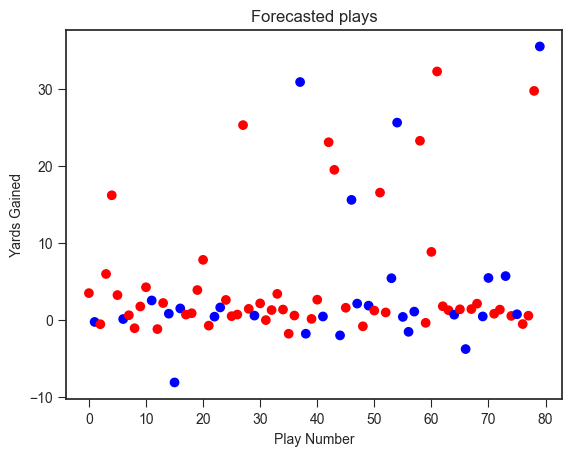

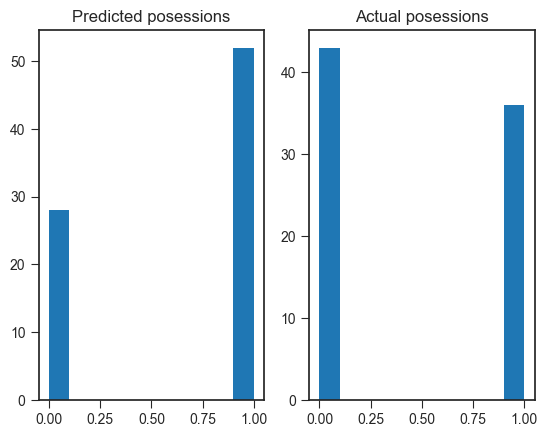

[1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0
 1 0 1 1 1 0]


In [9]:
print(log_likelihood)

# Forecast the rest of the game
samples = my_hmm.sample(n_samples=80)
forecast = samples[0]
pred_pos = forecast[:,1].astype(int)





# Add a custom colormap
custom_cmap = mcolors.ListedColormap(['blue', 'red'])

# Plot
plt.title("Forecasted plays")
scatter = plt.scatter(np.arange(len(forecast)), forecast[:,0], c=pred_pos, cmap=custom_cmap)
plt.xlabel("Play Number")
plt.ylabel("Yards Gained")
plt.show()

# Compare with actual
plt.subplot(121)
plt.title("Predicted posessions")
plt.hist(forecast[:,1].astype(int))

plt.subplot(122)
plt.title("Actual posessions")
plt.hist(second_posessions.to_numpy().astype(int))

plt.show()

print(forecast[:,1].astype(int))